# Example notebook for removing a solar flare from your data

## Assumptions are:

1. You have checked the background report and confirmed a solar flare is present
2. You have used the (GOES Example)[https://github.com/NuSTAR/nustar-gen-utils/blob/main/notebooks/GOES_example.ipynb] notebook to confirm that the flare is present
3. You have produced low energy (3-6 keV) lightcurves with time resolution to catch the flare.

In this example we know that there is a solar flare at the start of an orbit and have used realtively coare 1000-s bins to make the lightcurves.

**Note: The code in this example _will not work_ with the example data provided in this repository. Is is provided as a template for you to to use with your own observations.**

In [1]:
from importlib import reload
import matplotlib.pyplot as plt
from astropy.io.fits import getdata, getheader
import os
from nustar_gen import info, utils, wrappers
import numpy as np
reload(wrappers)
obs = info.Observation(seqid='91001341002', path='./', evdir='91001341002/event_cl_standard')

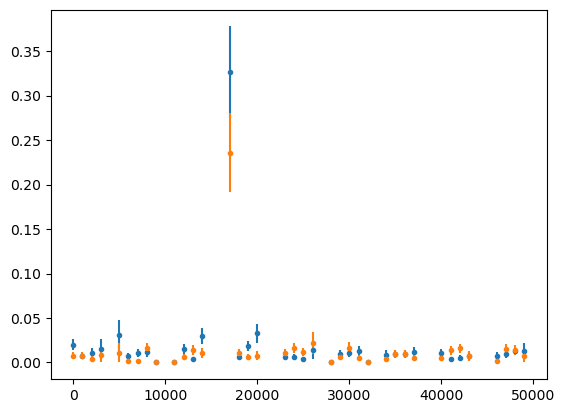

In [2]:


lc1f = '91001341002/event_cl_standard/nu91001341002A01_srcA_3to6_1e+03s_sr.lc'
lc2f = '91001341002/event_cl_standard/nu91001341002B01_srcB_3to6_1e+03s_sr.lc'

lc1 = getdata(lc1f)
hdr1 = getheader(lc1f,1)

lc2 = getdata(lc2f)
hdr2 = getheader(lc2f,1)


ax = plt.figure().subplots()

ax.errorbar(lc1['TIME'], lc1['RATE'], lc1['ERROR'], fmt = '.')
ax.errorbar(lc2['TIME'], lc2['RATE'], lc2['ERROR'], fmt = '.')

plt.show()

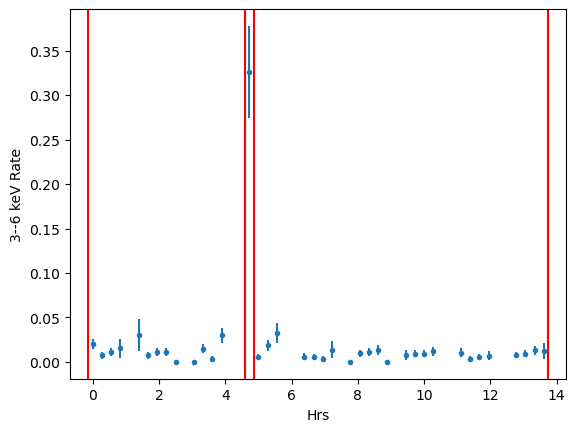

In [3]:
ax = plt.figure().subplots()
ax.errorbar(lc1['TIME']/3600, lc1['RATE'], lc1['ERROR'], fmt = '.')

# Make as many pairs as you need here to filter out the high lightcurve bins.
gti_pairs = [[-500, 16.5e3],
             [17.5e3, lc2['TIME'].max()+500]]
for gti in gti_pairs:
    ax.axvline(gti[0]/3600, color = 'red')
    ax.axvline(gti[1]/3600, color = 'red')
    
# ax.axvline(-1e3)
# ax.axvline(4e3)


# ax.axvline(22e3)
# ax.axvline(44.5e3)
# ax.axvline(51.3e3)
# ax.axvline(80e3)
ax.set_xlabel('Hrs')
ax.set_ylabel('3--6 keV Rate')
plt.show()

# GTIs must be in NuSTAR MET seconds.

## Here we start at the beginning of the obsrevation, make a GTI that extends until just before the flare, and then use a second GTI from "after" the flare through the end of the observation.


In [4]:

reload(wrappers)
names = ['noflare']

gtis = []
for ind, gti in enumerate(gti_pairs):
    gti_str = {'START':gti[0]+hdr1['TIMEZERO'],
               'STOP':gti[1]+hdr1['TIMEZERO']}

    gtis = np.append(gtis, gti_str)


gtifile = os.path.join(obs.out_path, f'noflare_usrgti.fits')
utils.make_usr_gti(gtis, overwrite=True, outfile = gtifile)


# Below are examples showing how to use the wrapper scripts with a user GTI file as input.

## You do not *have* to rerun from the initial nupipeline step if you do not want to. Below are examples that start at the nuproducts phase of NuSTARDAS

In [5]:
import astropy.units as u

tbin = 1000 * u.s
for mod in ['A', 'B']:
    
    evfile = obs.science_files[mod][0]
    regfile = os.path.join(obs.out_path, f'src{mod}.reg')
    print(regfile)

    pairs = [[3, 20]]

    for [elow, ehigh] in pairs:
        shfile = wrappers.make_lightcurve(evfile, mod, regfile,
                                 elow=elow, ehigh=ehigh, usrgti=gtifile,
                                 outpath=obs.out_path, time_bin = tbin)
    print(shfile)
print()

/Users/bwgref/science/AT2024wpp/91001341002/event_cl_standard/srcA.reg
/Users/bwgref/science/AT2024wpp/91001341002/event_cl_standard/runlc_nu91001341002A01_srcA_3to20_1e+03s_noflare_usrgti.sh
/Users/bwgref/science/AT2024wpp/91001341002/event_cl_standard/srcB.reg
/Users/bwgref/science/AT2024wpp/91001341002/event_cl_standard/runlc_nu91001341002B01_srcB_3to20_1e+03s_noflare_usrgti.sh



# The above scripts need to be run "by hand" in your shell. After you do that, proceed.

## Below is a check on the resulting lightcurve to ensure that the flare has been removed.

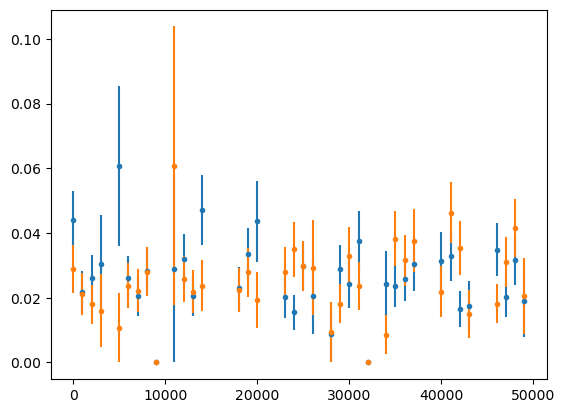

In [6]:
lc1f = '91001341002/event_cl_standard/nu91001341002A01_srcA_3to20_1e+03s_noflare_usrgti_sr.lc'
lc2f = '91001341002/event_cl_standard/nu91001341002B01_srcB_3to20_1e+03s_noflare_usrgti_sr.lc'

lc1 = getdata(lc1f)
hdr1 = getheader(lc1f,1)

lc2 = getdata(lc2f)
hdr2 = getheader(lc2f,1)


ax = plt.figure().subplots()

ax.errorbar(lc1['TIME'], lc1['RATE'], lc1['ERROR'], fmt = '.')
ax.errorbar(lc2['TIME'], lc2['RATE'], lc2['ERROR'], fmt = '.')

#ax.step(lc2['TIME'], lc2['RATE'])

plt.show()

# Finally, make a spectrum using the user GTI files

In [7]:
# Make spectra excluding the flare. Assumes you went and made bgd region files
for mod in ['A', 'B']:

    regfile = os.path.join(obs.out_path, f'src{mod}.reg')
    bgdfile =  os.path.join(obs.out_path, f'bgd{mod}.reg')
    wrappers.make_spectra(obs.evtfiles[mod][0], mod, regfile, usrgti=gtifile, bgd_reg=bgdfile)
    

# Above produces scripts in the out_path directory that need to be run by hand. After that, all analysis should continue as befits your science.